# NYCU Machine learning HW2 : Linear Discriminant Analysis 
## Written By 313511068 練鈞揚

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from itertools import combinations
from abc import ABC, abstractmethod
from rich import print

In [333]:
# setting
np.set_printoptions(precision=2, suppress=True)

In [334]:
LABEL = ["Setosa" , "Versicolor" , "Virginica" ]

COLOR_1 = dict(zip(LABEL, ["red" , "green" , "blue"]))
COLOR_2 = dict(zip(LABEL, ["pink" , "yellow" , "orange"]))
COLOR_3 = dict(zip(LABEL, ["brown", "lightgreen", "navy", "magenta"]))
COLOR_4 = dict(zip(LABEL, ["teal", "gold", "violet", "coral"]))

COLOR_SELECT = {
    "before": {
        "train":COLOR_1,
        "test":COLOR_2,
    },
    "after": {
        "train":COLOR_3,
        "test":COLOR_4,
    }
}

COLUMN_NAME = ["Sepal length", "Sepal width" , "Petal length" , "Petal width" , "Label"]
TRAIN_DATA_SIZE = 25

In [335]:
def load_iris_file(with_name:bool=False)->pd.DataFrame:
    df = pd.read_fwf("./iris.txt")
    
    df_new = pd.DataFrame({k:[v] for k ,v in zip(COLUMN_NAME , df.columns)},dtype=float)
    df.columns = COLUMN_NAME
    df_new = pd.concat([df_new, df], axis=0).reset_index().drop(columns=["index"])
    
    if not with_name:
        return df_new
    
    df_with_name = df_new.copy()
    
    df_with_name["Label"] = df_with_name["Label"].apply(lambda x : LABEL[int(x)-1])
    
    return df_with_name

In [336]:
df = load_iris_file(with_name=True)
df

,Sepal length,Sepal width,Petal length,Petal width,Label
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [337]:
POSITIVE_CLASS ,NEGATIVE_CLASS= "Versicolor" , "Virginica"

## Part 2

In [338]:
def build_dataset(df_in:pd.DataFrame) -> dict:
    df = df_in.drop(columns=["Sepal length",  "Sepal width"])
    positive_training_data = df[df["Label"]==POSITIVE_CLASS].copy()
    negative_training_data = df[df["Label"]==NEGATIVE_CLASS].copy()
    
    before_cross_train = [positive_training_data[:TRAIN_DATA_SIZE], negative_training_data[:TRAIN_DATA_SIZE]]
    before_cross_test = [positive_training_data[TRAIN_DATA_SIZE:] , negative_training_data[TRAIN_DATA_SIZE:]]

    def merge_dataset(df_list:list[pd.DataFrame]) -> pd.DataFrame:
        return pd.concat(df_list).reset_index().drop(columns=["index"])
    
    before_cross_train = merge_dataset(before_cross_train)
    before_cross_test = merge_dataset(before_cross_test)
    
    before_cross_dataset = {
        "train":before_cross_train,
        "test":before_cross_test,
    }
    
    after_cross_dataset = {
        "train":before_cross_test,
        "test":before_cross_train,
    }
        
    return {
        "before": before_cross_dataset , 
        "after":after_cross_dataset
    }

In [339]:
dataset = build_dataset(df)
dataset

{'before': {'train':     Petal length  Petal width       Label
  0            4.7          1.4  Versicolor
  1            4.5          1.5  Versicolor
  2            4.9          1.5  Versicolor
  3            4.0          1.3  Versicolor
  4            4.6          1.5  Versicolor
  5            4.5          1.3  Versicolor
  6            4.7          1.6  Versicolor
  7            3.3          1.0  Versicolor
  8            4.6          1.3  Versicolor
  9            3.9          1.4  Versicolor
  10           3.5          1.0  Versicolor
  11           4.2          1.5  Versicolor
  12           4.0          1.0  Versicolor
  13           4.7          1.4  Versicolor
  14           3.6          1.3  Versicolor
  15           4.4          1.4  Versicolor
  16           4.5          1.5  Versicolor
  17           4.1          1.0  Versicolor
  18           4.5          1.5  Versicolor
  19           3.9          1.1  Versicolor
  20           4.8          1.8  Versicolor
  21         

In [340]:
# check the data
assert all(dataset["before"]["train"] == dataset["after"]["test"])
assert all(dataset["before"]["test"] == dataset["after"]["train"])

In [341]:
def plot_data(dataset_in:dict,states:list[str],select_ds:list[str],axis_label:list[str] , func_dict:dict[str, dict]=None):
    if len(axis_label) > 2 :
        raise NotImplementedError
    
    label_lst = dataset_in[states[0]][select_ds[0]]["Label"].unique()
    
    # Step 1: Plot the points based on 'Label'
    for state in states:
        for select in select_ds:
            color_dict = COLOR_SELECT[state][select]
            df_select = dataset_in[state][select]
    
            for label, color in color_dict.items():
                if label not in label_lst:
                    continue
                
                # Filter the DataFrame for each label and plot
                subset = df_select[df_select['Label'] == label]
                plt.scatter(
                    subset[axis_label[0]], 
                    subset[axis_label[1]], 
                    color=color, 
                    label="_".join([label , state, select])
                )
    
    
    df_in = pd.concat([dataset_in[state][select] for select in select_ds for state in states])
    # plot the line
    if func_dict is not None:
        x_min , x_max = df_in[axis_label[0]].min(), df_in[axis_label[0]].max()
        x_values = np.arange(x_min , x_max,0.1)
        
        for state , func in func_dict.items():
            w =func["w"]
            b = func["b"]
            y_values = -(w[0] * x_values + b) / w[1]
            plt.plot(x_values, y_values, label=f'{state}: D(x) = {w}x + {b:.1f}')
    
    # Step 2: Customize the plot
    plt.title(f'{"+".join(states)}:{axis_label[0]} x {axis_label[1]}')
    plt.xlabel(f'{axis_label[0]} Axis')
    plt.ylabel(f'{axis_label[1]} Axis')
    plt.legend()  # Show legend for labels

    # Step 3: Show the plot
    plt.show()
    return 

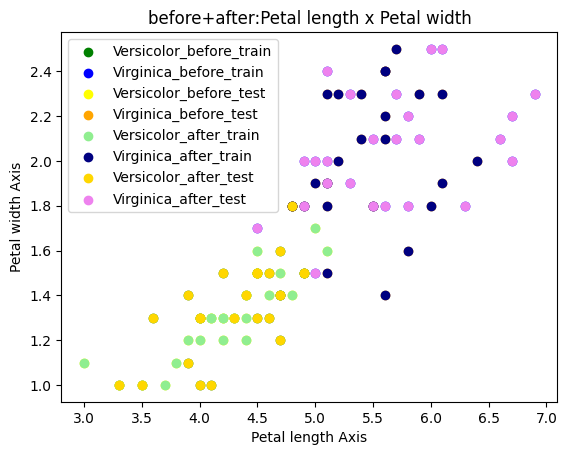

In [352]:
plot_data(
    dataset,
    states=["before" , "after"],
    select_ds=["train","test"],
    axis_label=["Petal length" ,"Petal width"],
)

In [343]:
class LdaTestAbc(ABC):
    
    @abstractmethod
    def fit(self, data_in:pd.DataFrame) -> None:
        raise NotImplementedError
    
    @abstractmethod
    def acc(self,x_df:pd.DataFrame)-> float:
        raise NotImplementedError
    
    @abstractmethod
    def func(self) -> dict:
        raise NotImplementedError

In [344]:
class Lda(LdaTestAbc):
    def __init__(self , positive_class:str , negative_class:str,  c1:int = 1, c2:int = 1):
        self._w :np.ndarray = None
        self._cov_matrix :np.ndarray= None
        self._b = None
        
        self._positive_class :str = positive_class 
        self._negative_class :str = negative_class
        self._display_class = [self._negative_class ,self._positive_class]
        self._c1 = c1
        self._c2 = c2
        return
    
    @property
    def w(self)->np.ndarray:
        return self._w
    
    @property
    def b(self):
        return self._b
    
    @property
    def c(self):
        return self._c1 , self._c2
    
    @property
    def cov_matrix(self)->np.ndarray:
        return self._cov_matrix
    
    @staticmethod
    def _build_mean_and_cov(data_in: np.ndarray):
        mean  = np.mean(data_in , axis=0)
        cov = np.cov(data_in.T)
        return mean , cov
    
    def fit(self , data_in:pd.DataFrame)->None:
        positive_data = data_in[data_in["Label"] == self._positive_class]
        negative_data = data_in[data_in["Label"] == self._negative_class]
        
        positive_data = positive_data.drop(columns=["Label"]).to_numpy()
        negative_data = negative_data.drop(columns=["Label"]).to_numpy()
        
        positive_mean , positive_cov = Lda._build_mean_and_cov(positive_data)
        negative_mean , negative_cov = Lda._build_mean_and_cov(negative_data)
        
        positive_len , negative_len = len(positive_data) , len(negative_data)
        
        total = positive_len + negative_len
        p1 , p2 = positive_len / total, negative_len / total
        
        # cov matrix
        self._cov_matrix = p1 * positive_cov + p2 * negative_cov
        
        inv_cov = np.linalg.pinv(self._cov_matrix)
        
        # weight
        self._w = (positive_mean - negative_mean).T @ inv_cov
        
        # b
        self._b = -(1/2)*(positive_mean - negative_mean).T @ inv_cov @ (positive_mean + negative_mean) - np.log((self._c1*p2)/ (self._c2*p1))
        
        return  
    
    def predict(self, x:np.ndarray) -> np.ndarray:
        return self._w.T @ x + self._b
    
    def predict_with_df(self, x_df:pd.DataFrame) -> np.ndarray:
        np_array = x_df.drop(columns=["Label"]).to_numpy().T
        result = self.predict(np_array)
        arr_item = np.array([self._display_class[int(item)] for item in result > 0])
        return arr_item
    
    def acc(self , x_df: pd.DataFrame)-> float:
        
        predict_out = self.predict_with_df(x_df)
        true_label = x_df["Label"]
        
        return float(sum(predict_out == true_label.to_numpy()) / len(true_label))
    
    def func(self) -> dict:
        return {"w":self._w , "b":self._b}
    
    def __call__(self,x:np.ndarray) -> np.ndarray:
        return self.predict(x)
    
    def __repr__(self) -> str:
        if self._w is None or self._b is None or self._cov_matrix is None:
            return "Model is not fitted"
        
        return f"Pos:{self._positive_class}, Neg: {self._negative_class}, W : {self._w} B : {self._b:.2f} Cov:{self._cov_matrix}"
    
    def __str__(self) -> str:
        if self._w is None or self._b is None or self._cov_matrix is None:
            return "Model is not fitted"
        
        return f"Pos:{self._positive_class}, Neg: {self._negative_class}\nW : {self._w}\nB : {self._b:.2f}\nCov:\n{self._cov_matrix}"
        

In [345]:
def test_model(model_in :LdaTestAbc , dataset_in:dict) -> tuple[str,dict]:
    
    def run_by_dataset(dataset_choose:str) -> str:
        model_in.fit(dataset_in[dataset_choose]["train"])
        out_str = f'{dataset_choose}:\n{str(model_in)}\n'
        
        acc = model_in.acc(dataset_in[dataset_choose]["test"])
        out_str += f"Acc :{acc*100:.2f}%\n\n"
        return out_str , acc , model_in.func()
    
    before_out , before_acc , before_func = run_by_dataset("before")
    after_out , after_acc, after_func = run_by_dataset("after")
    
    out_res_str = before_out + after_out
    avg_acc = (before_acc + after_acc) / 2
    
    out_res_str += f"Avg acc :{avg_acc*100:.2f}%"
    
    return out_res_str , {"before":before_func , "after":after_func}

In [346]:
lda_model = Lda(positive_class=POSITIVE_CLASS , negative_class=NEGATIVE_CLASS)

In [347]:
test_model_detail , test_model_func = test_model(model_in=lda_model,dataset_in=dataset)
print(test_model_detail)

before:
Pos:Versicolor, Neg: Virginica
W : [ -2.09 -10.46]
B : 28.10
Cov:
[[0.31 0.07]
 [0.07 0.05]]
Acc :94.00%

after:
Pos:Versicolor, Neg: Virginica
W : [-3.73 -7.85]
B : 31.08
Cov:
[[0.22 0.06]
 [0.06 0.06]]
Acc :94.00%

Avg acc :94.00%

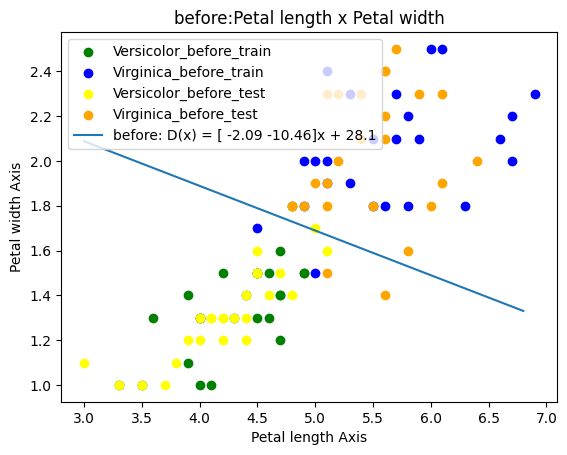

In [349]:
plot_data(
    dataset,
    states=["before" ], 
    select_ds=["train", "test"], 
    axis_label=["Petal length" ,"Petal width"],
    func_dict={"before":test_model_func["before"]}
)

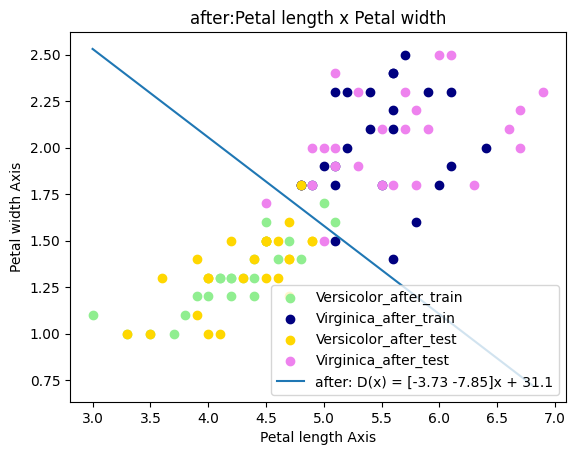

In [350]:
plot_data(
    dataset,
    states=["after"], 
    select_ds=["train", "test"], # "test"
    axis_label=["Petal length" ,"Petal width"],
    func_dict={"after":test_model_func["after"]}
)

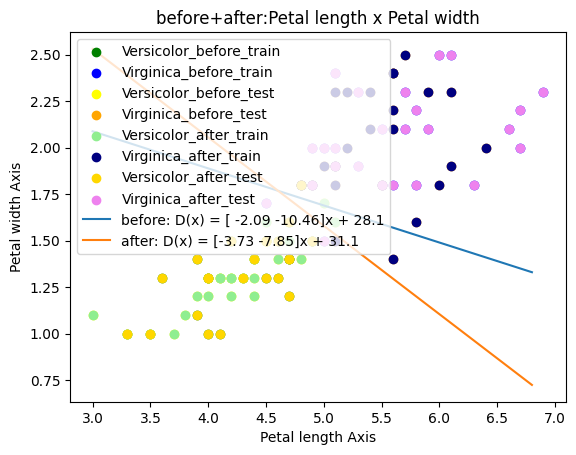

In [351]:
plot_data(
    dataset,
    states=["before" , "after"], 
    select_ds=["train", "test"], 
    axis_label=["Petal length" ,"Petal width"],
    func_dict=test_model_func
)

## Part 3

In [255]:
def build_multi_dataset(df_in:pd.DataFrame , class_list:list[str])-> dict:
    df = df_in.drop(columns=["Sepal length",  "Sepal width"])
    
    train_data_lst = [df[df["Label"]==class_name].copy() for class_name in class_list]
    
    before_cross_train = [item_df[:TRAIN_DATA_SIZE] for item_df in train_data_lst]
    before_cross_test = [item_df[TRAIN_DATA_SIZE:] for item_df in train_data_lst]

    def merge_dataset(df_list:list[pd.DataFrame]) -> pd.DataFrame:
        return pd.concat(df_list).reset_index().drop(columns=["index"])
    
    before_cross_train = merge_dataset(before_cross_train)
    before_cross_test = merge_dataset(before_cross_test)
    
    before_cross_dataset = {
        "train":before_cross_train,
        "test":before_cross_test,
    }
    
    after_cross_dataset = {
        "train":before_cross_test,
        "test":before_cross_train,
    }
        
    return {
        "before": before_cross_dataset , 
        "after":after_cross_dataset
    }

In [256]:
multi_dataset = build_multi_dataset(df , class_list=LABEL)
multi_dataset

{'before': {'train':     Petal length  Petal width      Label
  0            1.4          0.2     Setosa
  1            1.4          0.2     Setosa
  2            1.3          0.2     Setosa
  3            1.5          0.2     Setosa
  4            1.4          0.2     Setosa
  ..           ...          ...        ...
  70           5.7          2.3  Virginica
  71           4.9          2.0  Virginica
  72           6.7          2.0  Virginica
  73           4.9          1.8  Virginica
  74           5.7          2.1  Virginica
  
  [75 rows x 3 columns],
  'test':     Petal length  Petal width      Label
  0            1.6          0.2     Setosa
  1            1.6          0.4     Setosa
  2            1.5          0.2     Setosa
  3            1.4          0.2     Setosa
  4            1.6          0.2     Setosa
  ..           ...          ...        ...
  70           5.2          2.3  Virginica
  71           5.0          1.9  Virginica
  72           5.2          2.0  Virginica

In [257]:
# check the data
assert all(multi_dataset["before"]["train"] == multi_dataset["after"]["test"])
assert all(multi_dataset["before"]["test"] == multi_dataset["after"]["train"])

In [258]:
class LdaMultiple(LdaTestAbc):
    def __init__(self , class_list:list[str]):
        self._class_list = class_list
        self._combination_list = list(combinations(class_list, 2))
        self._models = [Lda(pos,neg) for pos , neg  in self._combination_list]        
        return
     
    @property
    def models(self):
        return self._models
    
    def fit(self, data_in:pd.DataFrame)->None:
        for i in range(len(self._models)):
            self._models[i].fit(data_in)
        return 
    
    def predict(self , x_df:pd.DataFrame) -> np.ndarray:
        pred = [item_model.predict_with_df(x_df) for item_model in self._models]
        
        res_np = np.array(pred).T
        
        def get_most_freq_by_row(row):
            unique , counts = np.unique(row , return_counts=True)
            return unique[np.argmax(counts)]
        
        res = np.array([get_most_freq_by_row(row) for row in res_np])
        return res
    
    def acc(self, x_df: pd.DataFrame)-> float:
        pred = self.predict(x_df)
        
        true_label = x_df["Label"].to_numpy()
        return float(np.sum(pred == true_label) / len(true_label))
    
    def __str__(self):
        class_list_str = f"Class list: {', '.join(self._class_list)}"
        return class_list_str+ "\n" + "\n".join(map(str, self._models))

In [259]:
multi_model = LdaMultiple(LABEL)

TypeError: Can't instantiate abstract class LdaMultiple with abstract method func

In [143]:
test_model_detail = test_model(multi_model , multi_dataset)
print(test_model_detail)

before:
Class list: Setosa, Versicolor, Virginica
Pos:Setosa, Neg: Versicolor
W : [-19.67 -15.01]
B : 68.72
Cov:
[[0.12 0.04]
 [0.04 0.03]]
Pos:Setosa, Neg: Virginica
W : [-12.65 -34.96]
B : 84.97
Cov:
[[0.23 0.04]
 [0.04 0.04]]
Pos:Versicolor, Neg: Virginica
W : [ -2.09 -10.46]
B : 28.10
Cov:
[[0.31 0.07]
 [0.07 0.05]]
Acc :96.00%

after:
Class list: Setosa, Versicolor, Virginica
Pos:Setosa, Neg: Versicolor
W : [-14.67 -17.11]
B : 54.87
Cov:
[[0.14 0.04]
 [0.04 0.02]]
Pos:Setosa, Neg: Virginica
W : [-34.15 -23.52]
B : 144.81
Cov:
[[0.11 0.02]
 [0.02 0.05]]
Pos:Versicolor, Neg: Virginica
W : [-3.73 -7.85]
B : 31.08
Cov:
[[0.22 0.06]
 [0.06 0.06]]
Acc :96.00%

Avg acc :96.00%